In [40]:
!pip install torchinfo torchmetrics transformers -q

In [68]:
import os
import random
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torchmetrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from torch import nn, optim
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.dataset import Dataset
from torchinfo import summary
from tqdm import tqdm
from transformers import BertConfig, BertForSequenceClassification, BertTokenizer

warnings.filterwarnings('ignore')

In [43]:
torch.__version__

'2.2.1+cu121'

In [44]:
!nvidia-smi

Mon Apr  8 10:43:46 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P0              27W /  70W |   1187MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [45]:
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)


def count_param(module: nn.Module, trainable=False) -> int:
    if trainable:
        return sum(p.numel() for p in module.parameters() if p.requires_grad)
    else:
        return sum(p.numel() for p in module.parameters())


def get_lr(optimizer: optim.Optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]


def freeze_layers(layers: nn.Module) -> None:
    for layer in layers.parameters():
        layer.requires_grad = False


def metrics_to_string(metric_dict: dict) -> str:
    string_list = []
    for key, value in metric_dict.items():
        string_list.append("{}:{:.2f}".format(key, value))
    return " ".join(string_list)

In [46]:
set_seed(2024)

In [47]:
device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cuda'

In [48]:
class DocumentSentimentDataset(Dataset):
    # Static constant variable
    LABEL2INDEX = {"positive": 0, "neutral": 1, "negative": 2}
    INDEX2LABEL = {0: "positive", 1: "neutral", 2: "negative"}
    NUM_LABELS = 3

    def load_dataset(self, path):
        df = pd.read_csv(path)
        df.columns = ["text", "sentiment"]
        df["sentiment"] = df["sentiment"].apply(lambda lab: self.LABEL2INDEX[lab])
        return df

    def __init__(
        self,
        dataset_path: str,
        tokenizer: BertTokenizer,
        no_special_token=False,
        *args,
        **kwargs,
    ):
        self.data = self.load_dataset(dataset_path)
        self.tokenizer = tokenizer
        self.no_special_token = no_special_token

    def __getitem__(self, index):
        data = self.data.loc[index, :]
        text, sentiment = data["text"], data["sentiment"]
        subwords = self.tokenizer.encode(
            text, add_special_tokens=not self.no_special_token
        )
        return np.array(subwords), np.array(sentiment), data["text"]

    def __len__(self):
        return len(self.data)

In [49]:
class DocumentSentimentDataLoader(DataLoader):
    def __init__(self, max_seq_len=512, *args, **kwargs):
        super(DocumentSentimentDataLoader, self).__init__(*args, **kwargs)
        self.collate_fn = self._collate_fn
        self.max_seq_len = max_seq_len

    def _collate_fn(self, batch):
        batch_size = len(batch)
        max_seq_len = max(map(lambda x: len(x[0]), batch))
        max_seq_len = min(self.max_seq_len, max_seq_len)

        subword_batch = np.zeros((batch_size, max_seq_len), dtype=np.int64)
        mask_batch = np.zeros((batch_size, max_seq_len), dtype=np.float32)
        sentiment_batch = np.zeros((batch_size, 1), dtype=np.int64)

        seq_list = []
        for i, (subwords, sentiment, raw_seq) in enumerate(batch):
            subwords = subwords[:max_seq_len]
            subword_batch[i, : len(subwords)] = subwords
            mask_batch[i, : len(subwords)] = 1
            sentiment_batch[i, 0] = sentiment

            seq_list.append(raw_seq)

        return subword_batch, mask_batch, sentiment_batch, seq_list

In [50]:
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p1")
config = BertConfig.from_pretrained("indobenchmark/indobert-base-p1")
config.num_labels = 3


model = BertForSequenceClassification.from_pretrained(
    "indobenchmark/indobert-base-p1", config=config
).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [51]:
# freeze_layers(model.bert.embeddings)
# freeze_layers(model.bert.encoder.layer[:-3])
# freeze_layers(model.bert.encoder)

In [52]:
summary(
    model=model,
    input_size=(1, 7),
    dtypes=[torch.long],
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=16,
    row_settings=["var_names"],
)

Layer (type (var_name))                                                Input Shape      Output Shape     Param #          Trainable
BertForSequenceClassification (BertForSequenceClassification)          [1, 7]           [1, 3]           --               True
├─BertModel (bert)                                                     [1, 7]           [1, 768]         --               True
│    └─BertEmbeddings (embeddings)                                     --               [1, 7, 768]      --               True
│    │    └─Embedding (word_embeddings)                                [1, 7]           [1, 7, 768]      38,400,000       True
│    │    └─Embedding (token_type_embeddings)                          [1, 7]           [1, 7, 768]      1,536            True
│    │    └─Embedding (position_embeddings)                            [1, 7]           [1, 7, 768]      393,216          True
│    │    └─LayerNorm (LayerNorm)                                      [1, 7, 768]      [1, 7, 768]      1

In [53]:
train_path = "tws-train.csv"
test_path = "tws-test.csv"

In [54]:
train_dataset = DocumentSentimentDataset(train_path, tokenizer, lowercase=True)
test_dataset = DocumentSentimentDataset(test_path, tokenizer, lowercase=True)

In [55]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader = DocumentSentimentDataLoader(
    dataset=train_dataset,
    max_seq_len=512,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

test_dataloader = DocumentSentimentDataLoader(
    dataset=test_dataset,
    max_seq_len=512,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

In [56]:
NUM_WORKERS

2

In [57]:
w2i, i2w = DocumentSentimentDataset.LABEL2INDEX, DocumentSentimentDataset.INDEX2LABEL
w2i, i2w

({'positive': 0, 'neutral': 1, 'negative': 2},
 {0: 'positive', 1: 'neutral', 2: 'negative'})

In [58]:
# Forward function for sequence classification
def forward_sequence_classification(
    model: BertForSequenceClassification,
    batch_data,
    i2w,
    is_test=False,
    device=device,
    **kwargs,
):
    # Unpack batch data
    if len(batch_data) == 3:
        (subword_batch, mask_batch, label_batch) = batch_data
        token_type_batch = None
    elif len(batch_data) == 4:
        (subword_batch, mask_batch, token_type_batch, label_batch) = batch_data

    # Prepare input & label
    subword_batch = torch.LongTensor(subword_batch)
    mask_batch = torch.FloatTensor(mask_batch)
    token_type_batch = (
        torch.LongTensor(token_type_batch) if token_type_batch is not None else None
    )
    label_batch = torch.LongTensor(label_batch)

    if device == "cuda":
        subword_batch = subword_batch.cuda()
        mask_batch = mask_batch.cuda()
        token_type_batch = (
            token_type_batch.cuda() if token_type_batch is not None else None
        )
        label_batch = label_batch.cuda()

    # Forward model
    outputs = model(
        subword_batch,
        attention_mask=mask_batch,
        token_type_ids=token_type_batch,
        labels=label_batch,
    )
    loss, logits = outputs[:2]

    # generate prediction & label list
    list_hyp = []
    list_label = []
    hyp = torch.topk(logits, 1)[1]
    for j in range(len(hyp)):
        list_hyp.append(i2w[hyp[j].item()])
        list_label.append(i2w[label_batch[j][0].item()])

    return loss, list_hyp, list_label

In [59]:
def document_sentiment_metrics_fn(list_hyp, list_label):
    metrics = {}
    metrics["ACC"] = accuracy_score(list_label, list_hyp)
    metrics["F1"] = f1_score(list_label, list_hyp, average="macro")
    metrics["REC"] = recall_score(list_label, list_hyp, average="macro")
    metrics["PRE"] = precision_score(list_label, list_hyp, average="macro")
    return metrics

In [60]:
optimizer = optim.Adam(
    model.parameters(),
    lr=3e-6,
    weight_decay=0.3,
)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, threshold=0.0001, threshold_mode='abs')

In [75]:
epochs = 100

train_loss_values = []
test_loss_values = []
train_metrics_values = []
test_metrics_values = []

for epoch in range(epochs):
    model.train()

    total_train_loss = 0
    list_hyp, list_label = [], []

    train_pbar = tqdm(train_dataloader, leave=True, total=len(train_dataloader))
    for i, batch_data in enumerate(train_pbar):
        # Forward model
        loss, batch_hyp, batch_label = forward_sequence_classification(
            model, batch_data[:-1], i2w=i2w, device="cuda"
        )

        # Update model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss = total_train_loss + loss.item()

        # Calculate metrics
        list_hyp += batch_hyp
        list_label += batch_label

        train_pbar.set_description(f"(Epoch {epoch+1}) TRAIN LOSS:{total_train_loss / (i+1):.4f} LR:{get_lr(optimizer):.6f}")

    # Calculate train metric
    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    print(f"(Epoch {epoch+1}) TRAIN LOSS:{total_train_loss / (i+1):.4f} {metrics_to_string(metrics)} LR:{get_lr(optimizer):.6f}")
    train_loss_values.append(total_train_loss)
    train_metrics_values.append(metrics['ACC'])

    # Evaluate on validation
    model.eval()

    total_loss, total_correct, total_labels = 0, 0, 0
    list_hyp, list_label = [], []

    test_pbar = tqdm(test_dataloader, leave=True, total=len(test_dataloader))
    with torch.inference_mode():
        for i, batch_data in enumerate(test_pbar):
            batch_seq = batch_data[-1]
            loss, batch_hyp, batch_label = forward_sequence_classification(
                model, batch_data[:-1], i2w=i2w, device="cuda"
            )

            # Calculate total loss
            valid_loss = loss.item()
            total_loss = total_loss + valid_loss

            # Calculate evaluation metrics
            list_hyp += batch_hyp
            list_label += batch_label
            test_pbar.set_description(f"VALID LOSS:{total_loss / (i+1):.4f} {metrics_to_string(metrics)}")

    # Update model
    scheduler.step(total_loss)

    metrics = document_sentiment_metrics_fn(list_hyp, list_label)
    print(f"(Epoch {epoch+1}) VALID LOSS:{total_loss / (i+1):.4f} {metrics_to_string(metrics)}")
    test_loss_values.append(total_loss)
    test_metrics_values.append(metrics['ACC'])

(Epoch 1) TRAIN LOSS:0.4449 LR:0.000003: 100%|██████████| 150/150 [00:27<00:00,  5.52it/s]


(Epoch 1) TRAIN LOSS:0.4449 ACC:0.86 F1:0.87 REC:0.86 PRE:0.87 LR:0.000003


VALID LOSS:0.4197 ACC:0.86 F1:0.87 REC:0.86 PRE:0.87: 100%|██████████| 38/38 [00:02<00:00, 14.32it/s]


(Epoch 1) VALID LOSS:0.4197 ACC:0.87 F1:0.88 REC:0.87 PRE:0.88


(Epoch 2) TRAIN LOSS:0.3794 LR:0.000003:  12%|█▏        | 18/150 [00:03<00:28,  4.61it/s]


KeyboardInterrupt: 

In [ ]:
model.save_pretrained(save_directory="indobert-sentiment-analysis")

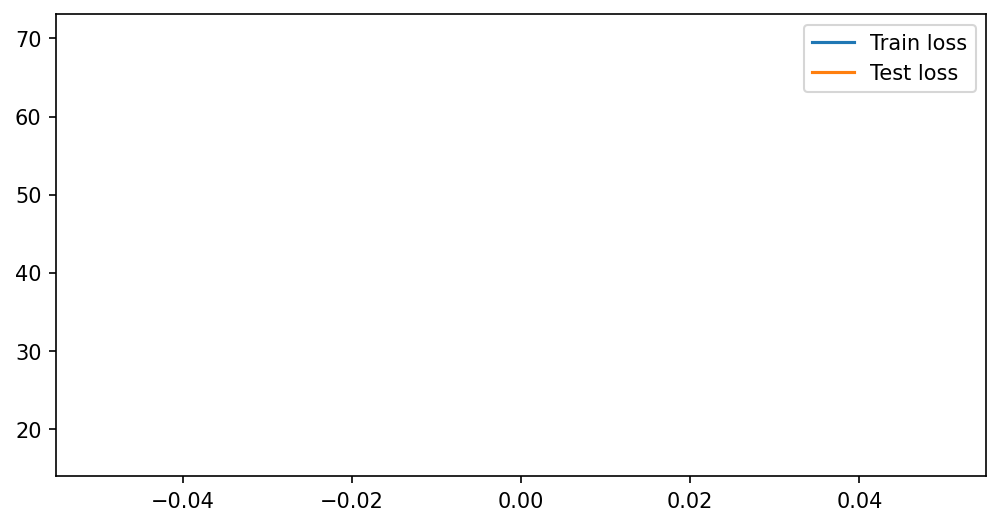

In [74]:
plt.figure(figsize=(8, 4), dpi=150)
plt.plot(range(epochs), train_loss_values, label="Train loss")
plt.plot(range(epochs), test_loss_values, label="Test loss")
plt.legend()

ValueError: x and y must have same first dimension, but have shapes (100,) and (1,)

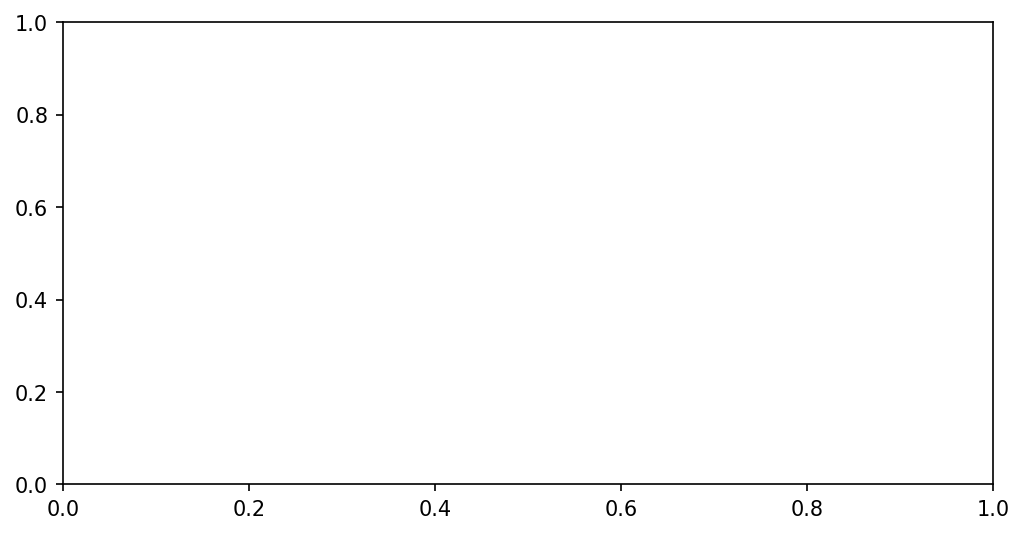

In [76]:
plt.figure(figsize=(8, 4), dpi=150)
plt.plot(range(epochs), train_metrics_values, label="Train accuracy")
plt.plot(range(epochs), test_metrics_values, label="Test accuracy")
plt.legend()

In [64]:
model.eval()
with torch.inference_mode():
    total_loss, total_correct, total_labels = 0, 0, 0
    list_hyp, list_label = [], []

    pbar = tqdm(test_dataloader, leave=True, total=len(test_dataloader))
    for i, batch_data in enumerate(pbar):
        _, batch_hyp, batch_label = forward_sequence_classification(
            model, batch_data[:-1], i2w=i2w, device="cuda"
        )
        list_hyp.extend(batch_hyp)
        list_label.extend(batch_label)

# Save prediction
results_df = pd.DataFrame({"sentiment": list_hyp, "label": list_label}).reset_index(
    drop=True
)
results_df.to_csv("pred.csv", index=False)

100%|██████████| 38/38 [00:02<00:00, 16.22it/s]


In [65]:
cm = torchmetrics.ConfusionMatrix(task='multiclass', num_classes=3)

In [78]:
y_pred = torch.tensor(
    list(
        map(lambda y: 0 if y == 'positive' else 1 if y == 'neutral' else 2 , list_hyp)
    )
)
ground_truth = torch.tensor(
    list(
        map(lambda y: 0 if y == 'positive' else 1 if y == 'neutral' else 2 , list_label)
    )
)

conf_mat = cm(y_pred, ground_truth)

<Axes: >

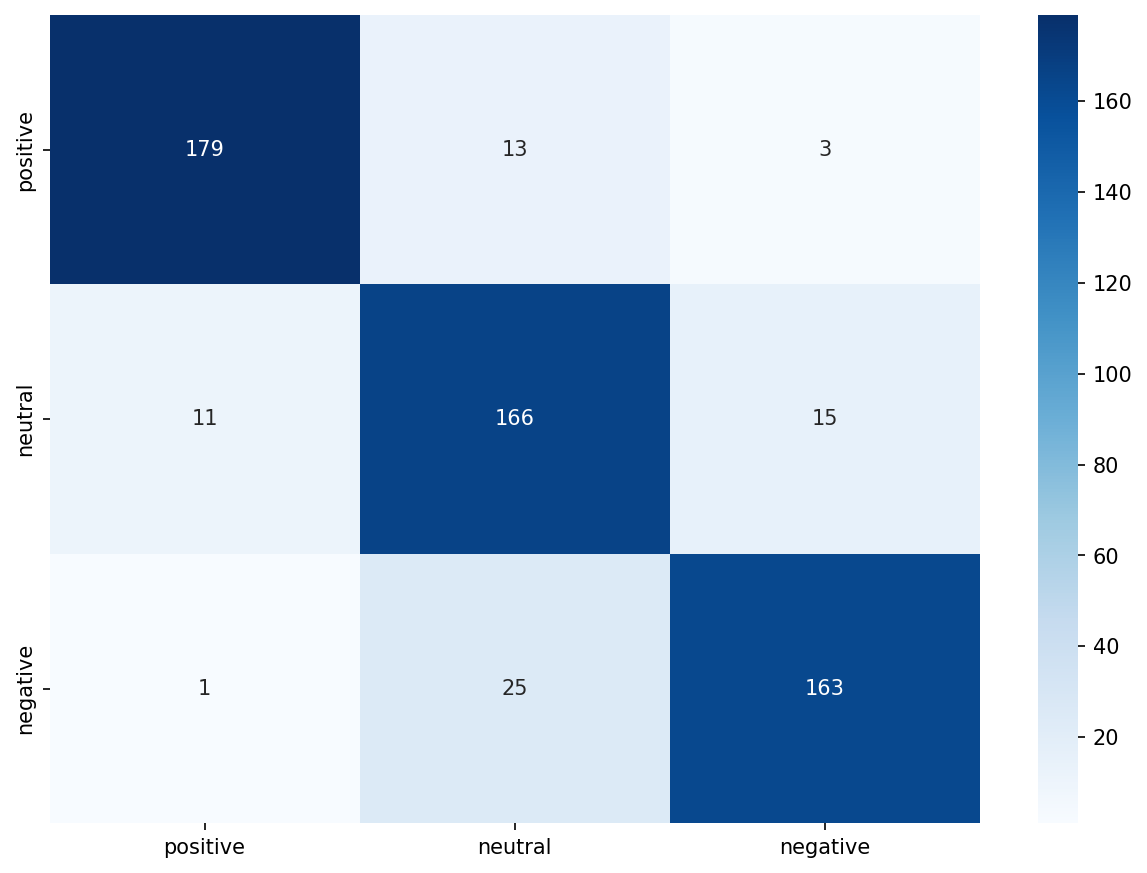

In [79]:
plt.figure(figsize=(10, 7), dpi=150)
sns.heatmap(
    conf_mat,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=w2i,
    yticklabels=w2i,
)

In [80]:
document_sentiment_metrics_fn(list_hyp, list_label)

{'ACC': 0.8819444444444444,
 'F1': 0.8823086864537643,
 'REC': 0.8816553045719712,
 'PRE': 0.8838169170843445}